In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
pip install deephit

     |████████████████████████████████| 347 kB 5.4 MB/s 
     |████████████████████████████████| 9.9 MB 65.0 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 110.5 MB 1.4 kB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 3.8 MB 52.3 MB/s 
     |████████████████████████████████| 503 kB 51.8 MB/s 
     |████████████████████████████████| 2.9 MB 39.9 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
INFO: pip is looking at multiple versions of scikit-learn to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpy to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 14.8 MB 

In [3]:
pip install tensorflow

In [4]:
#import tensorflow as tf
import numpy as np
from deephit import *


### CONSTRUCT MULTICELL FOR MULTI-LAYER RNNS
def create_rnn_cell(num_units, num_layers, keep_prob, RNN_type, activation_fn): 
    '''
        GOAL         : create multi-cell (including a single cell) to construct multi-layer RNN
        num_units    : number of units in each layer
        num_layers   : number of layers in MulticellRNN
        keep_prob    : keep probabilty [0, 1]  (if None, dropout is not employed)
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    if activation_fn == 'None':
        activation_fn = tf.nn.tanh

    cells = []
    for _ in range(num_layers):
        if RNN_type == 'GRU':
            cell = tf.contrib.rnn.GRUCell(num_units, activation=activation_fn)
        elif RNN_type == 'LSTM':
            cell = tf.contrib.rnn.LSTMCell(num_units, activation=activation_fn, state_is_tuple=True)
            # cell = tf.contrib.rnn.LSTMCell(num_units, activation=activation_fn)
        if not keep_prob is None:
            cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob) # state_keep_prob=keep_prob
        cells.append(cell)
    cell = tf.contrib.rnn.MultiRNNCell(cells)
    
    return cell


### EXTRACT STATE OUTPUT OF MULTICELL-RNNS
def create_concat_state(state, num_layers, RNN_type, BiRNN=None):
    '''
        GOAL	     : concatenate the tuple-type tensor (state) into a single tensor
        state        : input state is a tuple ofo MulticellRNN (i.e. output of MulticellRNN)
                       consist of only hidden states h for GRU and hidden states c and h for LSTM
        num_layers   : number of layers in MulticellRNN
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    for i in range(num_layers):
        if BiRNN != None:
            if RNN_type == 'LSTM':
                tmp = tf.concat([state[0][i][1], state[1][i][1]], axis=1) ## i-th layer, h state for LSTM
            elif RNN_type == 'GRU':
                tmp = tf.concat([state[0][i], state[1][i]], axis=1) ## i-th layer, h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')
        else:
            if RNN_type == 'LSTM':
                tmp = state[i][1] ## i-th layer, h state for LSTM
            elif RNN_type == 'GRU':
                tmp = state[i] ## i-th layer, h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')

        if i == 0:
            rnn_state_out = tmp
        else:
            rnn_state_out = tf.concat([rnn_state_out, tmp], axis = 1)
    
    return rnn_state_out


### FEEDFORWARD NETWORK
def create_FCNet(inputs, num_layers, h_dim, h_fn, o_dim, o_fn, w_init, w_reg=None, keep_prob=1.0):
    '''
        GOAL             : Create FC network with different specifications 
        inputs (tensor)  : input tensor
        num_layers       : number of layers in FCNet
        h_dim  (int)     : number of hidden units
        h_fn             : activation function for hidden layers (default: tf.nn.relu)
        o_dim  (int)     : number of output units
        o_fn             : activation function for output layers (defalut: None)
        w_init           : initialization for weight matrix (defalut: Xavier)
        keep_prob        : keep probabilty [0, 1]  (if None, dropout is not employed)
    '''
    # default active functions (hidden: relu, out: None)
    if h_fn is None:
        h_fn = tf.nn.relu
    if o_fn is None:
        o_fn = None

    # default initialization functions (weight: Xavier, bias: None)
    if w_init is None:
        w_init = tf.contrib.layers.xavier_initializer() # Xavier initialization

    for layer in range(num_layers):
        if num_layers == 1:
            out = FC_Net(inputs, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)
        else:
            if layer == 0:
                h = FC_Net(inputs, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            elif layer > 0 and layer != (num_layers-1): # layer > 0:
                h = FC_Net(h, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            else: # layer == num_layers-1 (the last layer)
                out = FC_Net(h, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)

    return out

In [5]:
def save_logging(dictionary, log_name):
    with open(log_name, 'w') as f:
        for key, value in dictionary.items():
            f.write('%s:%s\n' % (key, value))


def load_logging(filename):
    data = dict()
    with open(filename) as f:
        def is_float(input):
            try:
                num = float(input)
            except ValueError:
                return False
            return True

        for line in f.readlines():
            if ':' in line:
                key,value = line.strip().split(':', 1)
                if value.isdigit():
                    data[key] = int(value)
                elif is_float(value):
                    data[key] = float(value)
                elif value == 'None':
                    data[key] = None
                else:
                    data[key] = value
            else:
                pass # deal with bad lines of text here    
    return data

In [6]:
import numpy as np
import random

##### USER-DEFINED FUNCTIONS
def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask1 is required to get the contional probability (to calculate the denominator part)
        mask1 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask

def f_get_minibatch(mb_size, x, x_mi, label, time, mask1, mask2, mask3):
    idx = range(np.shape(x)[0])
    idx = random.sample(idx, mb_size)

    x_mb     = x[idx, :, :].astype(float)
    x_mi_mb  = x_mi[idx, :, :].astype(float)
    k_mb     = label[idx, :].astype(float) # censoring(0)/event(1,2,..) label
    t_mb     = time[idx, :].astype(float)
    m1_mb    = mask1[idx, :, :].astype(float) #fc_mask
    m2_mb    = mask2[idx, :, :].astype(float) #fc_mask
    m3_mb    = mask3[idx, :].astype(float) #fc_mask
    return x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb


def f_get_boosted_trainset(x, x_mi, time, label, mask1, mask2, mask3):
    _, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
    meas_time = np.concatenate([np.zeros([np.shape(x)[0], 1]), np.cumsum(x[:, :, 0], axis=1)[:, :-1]], axis=1)

    total_sample = 0
    for i in range(np.shape(x)[0]):
        total_sample += np.sum(np.sum(x[i], axis=1) != 0)

    new_label          = np.zeros([total_sample, np.shape(label)[1]])
    new_time           = np.zeros([total_sample, np.shape(time)[1]])
    new_x              = np.zeros([total_sample, np.shape(x)[1], np.shape(x)[2]])
    new_x_mi           = np.zeros([total_sample, np.shape(x_mi)[1], np.shape(x_mi)[2]])
    new_mask1          = np.zeros([total_sample, np.shape(mask1)[1], np.shape(mask1)[2]])
    new_mask2          = np.zeros([total_sample, np.shape(mask2)[1], np.shape(mask2)[2]])
    new_mask3          = np.zeros([total_sample, np.shape(mask3)[1]])

    tmp_idx = 0
    for i in range(np.shape(x)[0]):
        max_meas = np.sum(np.sum(x[i], axis=1) != 0)

        for t in range(max_meas):
            new_label[tmp_idx+t, 0] = label[i,0]
            new_time[tmp_idx+t, 0]  = time[i,0]

            new_x[tmp_idx+t,:(t+1), :] = x[i,:(t+1), :]
            new_x_mi[tmp_idx+t,:(t+1), :] = x_mi[i,:(t+1), :]

            new_mask1[tmp_idx+t, :, :] = f_get_fc_mask1(meas_time[i,t].reshape([-1,1]), num_Event, num_Category) #age at the measurement
            new_mask2[tmp_idx+t, :, :] = mask2[i, :, :]
            new_mask3[tmp_idx+t, :]    = mask3[i, :]

        tmp_idx += max_meas
        
    return(new_x, new_x_mi, new_time, new_label, new_mask1, new_mask2, new_mask3)


In [7]:
'''
Implemented: 02/12/2018
  > For survival analysis evaluation

First implemented by Kartik Ahuja
Modified by CHANGHEE LEE

Modifcation List:
	- 08/08/2018: Brier Score added
'''

import numpy as np
from lifelines import KaplanMeierFitter


### C(t)-INDEX CALCULATION
def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

### BRIER-SCORE
def brier_score(Prediction, Time_survival, Death, Time):
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)

    return np.mean((Prediction - y_true)**2)

    # result2[k, t] = brier_score_loss(risk[:, k], ((te_time[:,0] <= eval_horizon) * (te_label[:,0] == k+1)).astype(int))


##### WEIGHTED C-INDEX & BRIER-SCORE
def CensoringProb(Y, T):

    T = T.reshape([-1]) # (N,) - np array
    Y = Y.reshape([-1]) # (N,) - np array

    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=(Y==0).astype(int))  # censoring prob = survival probability of event "censoring"
    G = np.asarray(kmf.survival_function_.reset_index()).transpose()
    G[1, G[1, :] == 0] = G[1, G[1, :] != 0][-1]  #fill 0 with ZoH (to prevent nan values)
    
    return G



### C(t)-INDEX CALCULATION
def weighted_c_index(T_train, Y_train, Prediction, T_test, Y_test, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    G = CensoringProb(Y_train, T_train)

    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        tmp_idx = np.where(G[0,:] >= T_test[i])[0]

        if len(tmp_idx) == 0:
            W = (1./G[1, -1])**2
        else:
            W = (1./G[1, tmp_idx[0]])**2

        A[i, np.where(T_test[i] < T_test)] = 1. * W
        Q[i, np.where(Prediction[i] > Prediction)] = 1. # give weights

        if (T_test[i]<=Time and Y_test[i]==1):
            N_t[i,:] = 1.

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result


def weighted_brier_score(T_train, Y_train, Prediction, T_test, Y_test, Time):
    G = CensoringProb(Y_train, T_train)
    N = len(Prediction)

    W = np.zeros(len(Y_test))
    Y_tilde = (T_test > Time).astype(float)

    for i in range(N):
        tmp_idx1 = np.where(G[0,:] >= T_test[i])[0]
        tmp_idx2 = np.where(G[0,:] >= Time)[0]

        if len(tmp_idx1) == 0:
            G1 = G[1, -1]
        else:
            G1 = G[1, tmp_idx1[0]]

        if len(tmp_idx2) == 0:
            G2 = G[1, -1]
        else:
            G2 = G[1, tmp_idx2[0]]
        W[i] = (1. - Y_tilde[i])*float(Y_test[i])/G1 + Y_tilde[i]/G2

    y_true = ((T_test <= Time) * Y_test).astype(float)

    return np.mean(W*(Y_tilde - (1.-Prediction))**2)



In [8]:
import numpy as np
import tensorflow as tf
import random

from tensorflow.contrib.layers import fully_connected as FC_Net
from tensorflow.python.ops.rnn import _transpose_batch_time


#import utils_network as utils

_EPSILON = 1e-08



##### USER-DEFINED FUNCTIONS
def log(x):
    return tf.log(x + _EPSILON)

def div(x, y):
    return tf.div(x, (y + _EPSILON))

def get_seq_length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
    tmp_length = tf.reduce_sum(used, 1)
    tmp_length = tf.cast(tmp_length, tf.int32)
    return tmp_length


class Model_Longitudinal_Attention:
    # def __init__(self, sess, name, mb_size, input_dims, network_settings):
    def __init__(self, sess, name, input_dims, network_settings):
        self.sess               = sess
        self.name               = name

        # INPUT DIMENSIONS
        self.x_dim              = input_dims['x_dim']
        self.x_dim_cont         = input_dims['x_dim_cont']
        self.x_dim_bin          = input_dims['x_dim_bin']

        self.num_Event          = input_dims['num_Event']
        self.num_Category       = input_dims['num_Category']
        self.max_length         = input_dims['max_length']

        # NETWORK HYPER-PARMETERS
        self.h_dim1             = network_settings['h_dim_RNN']
        self.h_dim2             = network_settings['h_dim_FC']
        self.num_layers_RNN     = network_settings['num_layers_RNN']
        self.num_layers_ATT     = network_settings['num_layers_ATT']
        self.num_layers_CS      = network_settings['num_layers_CS']

        self.RNN_type           = network_settings['RNN_type']

        self.FC_active_fn       = network_settings['FC_active_fn']
        self.RNN_active_fn      = network_settings['RNN_active_fn']
        self.initial_W          = network_settings['initial_W']
        
        self.reg_W              = tf.contrib.layers.l1_regularizer(scale=network_settings['reg_W'])
        self.reg_W_out          = tf.contrib.layers.l1_regularizer(scale=network_settings['reg_W_out'])

        self._build_net()


    def _build_net(self):
        with tf.variable_scope(self.name):
            #### PLACEHOLDER DECLARATION
            self.mb_size     = tf.placeholder(tf.int32, [], name='batch_size')

            self.lr_rate     = tf.placeholder(tf.float32)
            self.keep_prob   = tf.placeholder(tf.float32)                                                      #keeping rate
            self.a           = tf.placeholder(tf.float32)
            self.b           = tf.placeholder(tf.float32)
            self.c           = tf.placeholder(tf.float32)

            self.x           = tf.placeholder(tf.float32, shape=[None, self.max_length, self.x_dim])
            self.x_mi        = tf.placeholder(tf.float32, shape=[None, self.max_length, self.x_dim])           
            #this is the missing indicator (including for cont. & binary) (includes delta)
            self.k           = tf.placeholder(tf.float32, shape=[None, 1])                                     #event/censoring label (censoring:0)
            self.t           = tf.placeholder(tf.float32, shape=[None, 1])


            self.fc_mask1    = tf.placeholder(tf.float32, shape=[None, self.num_Event, self.num_Category])     #for denominator
            self.fc_mask2    = tf.placeholder(tf.float32, shape=[None, self.num_Event, self.num_Category])     #for Loss 1
            self.fc_mask3    = tf.placeholder(tf.float32, shape=[None, self.num_Category])                     #for Loss 2

            
            seq_length     = get_seq_length(self.x)
            tmp_range      = tf.expand_dims(tf.range(0, self.max_length, 1), axis=0)
            
            self.rnn_mask1 = tf.cast(tf.less_equal(tmp_range, tf.expand_dims(seq_length - 1, axis=1)), tf.float32)            
            self.rnn_mask2 = tf.cast(tf.equal(tmp_range, tf.expand_dims(seq_length - 1, axis=1)), tf.float32) 
            
            
            ### DEFINE LOOP FUNCTION FOR RAW_RNN w/ TEMPORAL ATTENTION
            def loop_fn_att(time, cell_output, cell_state, loop_state):

                emit_output = cell_output 

                if cell_output is None:  # time == 0
                    next_cell_state = cell.zero_state(self.mb_size, tf.float32)
                    next_loop_state = loop_state_ta
                else:
                    next_cell_state = cell_state
                    tmp_h = create_concat_state(next_cell_state, self.num_layers_RNN, self.RNN_type)

                    e = create_FCNet(tf.concat([tmp_h, all_last], axis=1), self.num_layers_ATT, self.h_dim2, 
                                           tf.nn.tanh, 1, None, self.initial_W, keep_prob=self.keep_prob)
                    e = tf.exp(e)

                    next_loop_state = (loop_state[0].write(time-1, e),                # save att power (e_{j})
                                       loop_state[1].write(time-1, tmp_h))  # save all the hidden states

                # elements_finished = (time >= seq_length)
                elements_finished = (time >= self.max_length-1)

                #this gives the break-point (no more recurrence after the max_length)
                finished = tf.reduce_all(elements_finished)    
                next_input = tf.cond(finished, lambda: tf.zeros([self.mb_size, 2*self.x_dim], dtype=tf.float32),  # [x_hist, mi_hist]
                                               lambda: inputs_ta.read(time))

                return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)


            
            # divide into the last x and previous x's
            x_last = tf.slice(self.x, [0,(self.max_length-1), 1], [-1,-1,-1])      #current measurement
            x_last = tf.reshape(x_last, [-1, (self.x_dim_cont+self.x_dim_bin)])    #remove the delta of the last measurement

            x_last = tf.reduce_sum(tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]) * self.x, reduction_indices=1)    #sum over time since all others time stamps are 0
            x_last = tf.slice(x_last, [0,1], [-1,-1])                               #remove the delta of the last measurement
            x_hist = self.x * (1.-tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]))                                    #since all others time stamps are 0 and measurements are 0-padded
            x_hist = tf.slice(x_hist, [0, 0, 0], [-1,(self.max_length-1),-1])  

            # do same thing for missing indicator
            mi_last = tf.slice(self.x_mi, [0,(self.max_length-1), 1], [-1,-1,-1])      #current measurement
            mi_last = tf.reshape(mi_last, [-1, (self.x_dim_cont+self.x_dim_bin)])    #remove the delta of the last measurement

            mi_last = tf.reduce_sum(tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]) * self.x_mi, reduction_indices=1)    #sum over time since all others time stamps are 0
            mi_last = tf.slice(mi_last, [0,1], [-1,-1])                               #remove the delta of the last measurement
            mi_hist = self.x_mi * (1.-tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]))                                    #since all others time stamps are 0 and measurements are 0-padded
            mi_hist = tf.slice(mi_hist, [0, 0, 0], [-1,(self.max_length-1),-1])  

            all_hist = tf.concat([x_hist, mi_hist], axis=2)
            all_last = tf.concat([x_last, mi_last], axis=1)


            #extract inputs for the temporal attention: mask (to incorporate only the measured time) and x_{M}
            seq_length     = get_seq_length(x_hist)
            rnn_mask_att   = tf.cast(tf.not_equal(tf.reduce_sum(x_hist, reduction_indices=2), 0), dtype=tf.float32)  #[mb_size, max_length-1], 1:measurements 0:no measurements
            

            ##### SHARED SUBNETWORK: RNN w/ TEMPORAL ATTENTION
            #change the input tensor to TensorArray format with [max_length, mb_size, x_dim]
            inputs_ta = tf.TensorArray(dtype=tf.float32, size=self.max_length-1).unstack(_transpose_batch_time(all_hist), name = 'Shared_Input')


            #create a cell with RNN hyper-parameters (RNN types, #layers, #nodes, activation functions, keep proability)
            cell = create_rnn_cell(self.h_dim1, self.num_layers_RNN, self.keep_prob, 
                                         self.RNN_type, self.RNN_active_fn)

            #define the loop_state TensorArray for information from rnn time steps
            loop_state_ta = (tf.TensorArray(size=self.max_length-1, dtype=tf.float32),  #e values (e_{j})
                             tf.TensorArray(size=self.max_length-1, dtype=tf.float32))  #hidden states (h_{j})
            
            rnn_outputs_ta, self.rnn_final_state, loop_state_ta = tf.nn.raw_rnn(cell, loop_fn_att)
            #rnn_outputs_ta  : TensorArray
            #rnn_final_state : Tensor
            #rnn_states_ta   : (TensorArray, TensorArray)

            rnn_outputs = _transpose_batch_time(rnn_outputs_ta.stack())
            # rnn_outputs =  tf.reshape(rnn_outputs, [-1, self.max_length-1, self.h_dim1])

            rnn_states  = _transpose_batch_time(loop_state_ta[1].stack())

            att_weight  = _transpose_batch_time(loop_state_ta[0].stack()) #e_{j}
            att_weight  = tf.reshape(att_weight, [-1, self.max_length-1]) * rnn_mask_att # masking to set 0 for the unmeasured e_{j}

            #get a_{j} = e_{j}/sum_{l=1}^{M-1}e_{l}
            self.att_weight  = div(att_weight,(tf.reduce_sum(att_weight, axis=1, keepdims=True) + _EPSILON)) #softmax (tf.exp is done, previously)

            # 1) expand att_weight to hidden state dimension, 2) c = \sum_{j=1}^{M} a_{j} x h_{j}
            self.context_vec = tf.reduce_sum(tf.tile(tf.reshape(self.att_weight, [-1, self.max_length-1, 1]), [1, 1, self.num_layers_RNN*self.h_dim1]) * rnn_states, axis=1)


            self.z_mean      = FC_Net(rnn_outputs, self.x_dim, activation_fn=None, weights_initializer=self.initial_W, scope="RNN_out_mean1")
            self.z_std       = tf.exp(FC_Net(rnn_outputs, self.x_dim, activation_fn=None, weights_initializer=self.initial_W, scope="RNN_out_std1"))

            epsilon          = tf.random_normal([self.mb_size, self.max_length-1, self.x_dim], mean=0.0, stddev=1.0, dtype=tf.float32)
            self.z           = self.z_mean + self.z_std * epsilon

            
            ##### CS-SPECIFIC SUBNETWORK w/ FCNETS 
            inputs = tf.concat([x_last, self.context_vec], axis=1)


            #1 layer for combining inputs
            h = FC_Net(inputs, self.h_dim2, activation_fn=self.FC_active_fn, weights_initializer=self.initial_W, scope="Layer1")
            h = tf.nn.dropout(h, keep_prob=self.keep_prob)

            # (num_layers_CS-1) layers for cause-specific (num_Event subNets)
            out = []
            for _ in range(self.num_Event):
                cs_out = create_FCNet(h, (self.num_layers_CS), self.h_dim2, self.FC_active_fn, self.h_dim2, self.FC_active_fn, self.initial_W, self.reg_W, self.keep_prob)
                out.append(cs_out)
            out = tf.stack(out, axis=1) # stack referenced on subject
            out = tf.reshape(out, [-1, self.num_Event*self.h_dim2])
            out = tf.nn.dropout(out, keep_prob=self.keep_prob)

            out = FC_Net(out, self.num_Event * self.num_Category, activation_fn=tf.nn.softmax, 
                         weights_initializer=self.initial_W, weights_regularizer=self.reg_W_out, scope="Output")
            self.out = tf.reshape(out, [-1, self.num_Event, self.num_Category])


            ##### GET LOSS FUNCTIONS
            self.loss_Log_Likelihood()      #get loss1: Log-Likelihood loss
            self.loss_Ranking()             #get loss2: Ranking loss
            self.loss_RNN_Prediction()      #get loss3: RNN prediction loss

            self.LOSS_TOTAL     = self.a*self.LOSS_1 + self.b*self.LOSS_2 + self.c*self.LOSS_3 + tf.losses.get_regularization_loss()
            self.LOSS_BURNIN    = self.LOSS_3 + tf.losses.get_regularization_loss()

            self.solver         = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.LOSS_TOTAL)
            self.solver_burn_in = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.LOSS_BURNIN)


    ### LOSS-FUNCTION 1 -- Log-likelihood loss
    def loss_Log_Likelihood(self):
        sigma3 = tf.constant(1.0, dtype=tf.float32)

        I_1 = tf.sign(self.k)
        denom = 1 - tf.reduce_sum(tf.reduce_sum(self.fc_mask1 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True) # make subject specific denom.
        denom = tf.clip_by_value(denom, tf.cast(_EPSILON, dtype=tf.float32), tf.cast(1.-_EPSILON, dtype=tf.float32))

        #for uncenosred: log P(T=t,K=k|x,Y,t>t_M)
        tmp1 = tf.reduce_sum(tf.reduce_sum(self.fc_mask2 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True)
        tmp1 = I_1 * log(div(tmp1,denom))

        #for censored: log \sum P(T>t|x,Y,t>t_M)
        tmp2 = tf.reduce_sum(tf.reduce_sum(self.fc_mask2 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True)
        tmp2 = (1. - I_1) * log(div(tmp2,denom))

        self.LOSS_1 = - tf.reduce_mean(tmp1 + sigma3*tmp2)


    ### LOSS-FUNCTION 2 -- Ranking loss
    def loss_Ranking(self):
        sigma1 = tf.constant(0.1, dtype=tf.float32)

        eta = []
        for e in range(self.num_Event):
            one_vector = tf.ones_like(self.t, dtype=tf.float32)
            I_2 = tf.cast(tf.equal(self.k, e+1), dtype = tf.float32) #indicator for event
            I_2 = tf.diag(tf.squeeze(I_2))
            tmp_e = tf.reshape(tf.slice(self.out, [0, e, 0], [-1, 1, -1]), [-1, self.num_Category]) #event specific joint prob.

            R = tf.matmul(tmp_e, tf.transpose(self.fc_mask3)) #no need to divide by each individual dominator
            # r_{ij} = risk of i-th pat based on j-th time-condition (last meas. time ~ event time) , i.e. r_i(T_{j})

            diag_R = tf.reshape(tf.diag_part(R), [-1, 1])
            R = tf.matmul(one_vector, tf.transpose(diag_R)) - R # R_{ij} = r_{j}(T_{j}) - r_{i}(T_{j})
            R = tf.transpose(R)                                 # Now, R_{ij} (i-th row j-th column) = r_{i}(T_{i}) - r_{j}(T_{i})

            T = tf.nn.relu(tf.sign(tf.matmul(one_vector, tf.transpose(self.t)) - tf.matmul(self.t, tf.transpose(one_vector))))
            # T_{ij}=1 if t_i < t_j  and T_{ij}=0 if t_i >= t_j

            T = tf.matmul(I_2, T) # only remains T_{ij}=1 when event occured for subject i

            tmp_eta = tf.reduce_mean(T * tf.exp(-R/sigma1), reduction_indices=1, keepdims=True)

            eta.append(tmp_eta)
        eta = tf.stack(eta, axis=1) #stack referenced on subjects
        eta = tf.reduce_mean(tf.reshape(eta, [-1, self.num_Event]), reduction_indices=1, keepdims=True)

        self.LOSS_2 = tf.reduce_sum(eta) #sum over num_Events


    ### LOSS-FUNCTION 3 -- RNN prediction loss
    def loss_RNN_Prediction(self):
        tmp_x  = tf.slice(self.x, [0,1,0], [-1,-1,-1])  # (t=2 ~ M)
        tmp_mi = tf.slice(self.x_mi, [0,1,0], [-1,-1,-1])  # (t=2 ~ M)

        tmp_mask1  = tf.tile(tf.expand_dims(self.rnn_mask1, axis=2), [1,1,self.x_dim]) #for hisotry (1...J-1)
        tmp_mask1  = tmp_mask1[:, :(self.max_length-1), :] 

        zeta = tf.reduce_mean(tf.reduce_sum(tmp_mask1 * (1. - tmp_mi) * tf.pow(self.z - tmp_x, 2), reduction_indices=1))  #loss calculated for selected features.

        self.LOSS_3 = zeta

 
    def get_cost(self, DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb)        = DATA
        (m1_mb, m2_mb, m3_mb)     = MASK
        (x_mi_mb)                 = MISSING
        (alpha, beta, gamma)      = PARAMETERS
        return self.sess.run(self.LOSS_TOTAL, 
                             feed_dict={self.x:x_mb, self.x_mi: x_mi_mb, self.k:k_mb, self.t:t_mb, 
                                        self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, self.fc_mask3: m3_mb, 
                                        self.a:alpha, self.b:beta, self.c:gamma,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})

    def train(self, DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb)        = DATA
        (m1_mb, m2_mb, m3_mb)     = MASK
        (x_mi_mb)                 = MISSING
        (alpha, beta, gamma)      = PARAMETERS
        return self.sess.run([self.solver, self.LOSS_TOTAL], 
                             feed_dict={self.x:x_mb, self.x_mi: x_mi_mb, self.k:k_mb, self.t:t_mb,
                                        self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, self.fc_mask3: m3_mb, 
                                        self.a:alpha, self.b:beta, self.c:gamma,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})
    
    def train_burn_in(self, DATA, MISSING, keep_prob, lr_train):
        (x_mb, k_mb, t_mb)        = DATA
        (x_mi_mb)                 = MISSING

        return self.sess.run([self.solver_burn_in, self.LOSS_3], 
                             feed_dict={self.x:x_mb, self.x_mi: x_mi_mb, self.k:k_mb, self.t:t_mb, 
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})
    
    def predict(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.out, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_z(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.z, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_rnnstate(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.rnn_final_state, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_att(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.att_weight, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_context_vec(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.context_vec, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def get_z_mean_and_std(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run([self.z_mean, self.z_std], feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

In [9]:
_EPSILON = 1e-08

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os

from sklearn.model_selection import train_test_split

#import import_data as impt

#from class_DeepLongitudinal import Model_Longitudinal_Attention

#from utils_eval             import c_index, brier_score
#from utils_log              import save_logging, load_logging
#from utils_helper           import f_get_minibatch, f_get_boosted_trainset

In [10]:
from sklearn.preprocessing import LabelEncoder as lbe


In [11]:
import pandas as pd
import numpy as np



##### USER-DEFINED FUNCTIONS
def f_get_Normalization(X, norm_mode):    
    num_Patient, num_Feature = np.shape(X)
    
    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.nanstd(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))/np.nanstd(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.nanmin(X[:,j]))/(np.nanmax(X[:,j]) - np.nanmin(X[:,j]))
    else:
        print("INPUT MODE ERROR!")
    
    return X


def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask3 is required to get the contional probability (to calculate the denominator part)
        mask3 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask


def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss 
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category]. 
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements 
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask



##### TRANSFORMING DATA
def f_construct_dataset(df, feat_list):
    '''
        id   : patient indicator
        tte  : time-to-event or time-to-censoring
            - must be synchronized based on the reference time
        time: time at which observations are measured
            - must be synchronized based on the reference time (i.e., times start from 0)
        label: event/censoring information
            - 0: censoring
            - 1: event type 1
            - 2: event type 2
            ...
    '''

    grouped  = df.groupby(['ID'])
    id_list  = pd.unique(df['ID'])
    max_meas = np.max(grouped.count())[0]

    data     = np.zeros([len(id_list), max_meas, len(feat_list)+1])
    pat_info = np.zeros([len(id_list), 5])

    for i, tmp_id in enumerate(id_list):
        tmp = grouped.get_group(tmp_id).reset_index(drop=True)

        pat_info[i,4] = tmp.shape[0]                                   #number of measurement
        pat_info[i,3] = np.max(tmp['time'])     #last measurement time
        pat_info[i,2] = tmp['label'][0]      #cause
        pat_info[i,1] = tmp['tte'][0]         #time_to_event
        pat_info[i,0] = tmp['ID'][0]      

        data[i, :int(pat_info[i, 4]), 1:]  = tmp[feat_list]
        data[i, :int(pat_info[i, 4]-1), 0] = np.diff(tmp['time'])
    
    return pat_info, data


def import_dataset(norm_mode = 'standard'):

    df_  = pd.read_csv('/content/dataset_completo_modelli.txt' , sep = ' ')

    df_['time'] = df_['tstart']

    df_['label'] = df_['CVD1_COD_15']
    for i in np.unique(df_['ID']):
      if sum(df_.loc[df_.index[df_['ID']==i],'label'])>0:
        df_.loc[df_.index[df_['ID']==i],'label'] = 1
    df_['time_CVD1'] = np.float32(np.where( df_['time_CVD1'] == 'non evento' , 0 , df_['time_CVD1']))
    df_['tte'] = np.where(df_['label'] == 1 , df_['time_CVD1'], df_['end'] )

    df_[['SESSO']] = np.where(df_[['SESSO']]=='F',1,0) 
    df_[['anno_inizio_ARV']] = np.where(df_[['anno_inizio_ARV']]=='<=2007',1,0) 
    df_[['FDRn']] = np.where(df_[['FDRn']]=='MSM',1,0)
    df_[['HCV']] = np.float32(np.where(df_[['HCV']]=='non noto',0,df_[['HCV']]))
    df_[['HBV']] = np.float32(np.where(df_[['HBV']]=='non noto',0,df_[['HBV']]))

    bin_list           = ['anno_inizio_ARV' ,  'FDRn','HCV' ]
    cont_list          = [ 'AGE_UPD' ,'ipert_si_no'   , 'PLT' ,
                            'INI_time_exp' , "PI_time_exp" , 'NNRTI_time_exp']
    feat_list          = cont_list + bin_list
    df_                = df_[['ID', 'tte', 'time', 'label']  + feat_list]
    df_ = df_.dropna()
    print(df_.loc[1,'ID':'HCV'])
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 1.2) #or specifically define larger than the max tte
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi




def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)



def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

### 1. Import Dataset
#####      - Users must prepare dataset in csv format and modify 'import_data.py' following our examplar 'PBC2'

In [12]:
data_mode                   = 'PBC2' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'PBC2':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard')
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    #pred_time = [2,5,8,11,15] # prediction time (in months)
    #eval_time = [2,5,8,11,15] # months evaluation time (for C-index and Brier-Score)
    pred_time = np.arange(0,16,1)
    eval_time = np.arange(0,16,1) # prediction time (in months)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1] 


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

ID                 48.000000
tte                14.266000
time                0.000000
label               1.000000
AGE_UPD            49.295003
ipert_si_no         0.000000
PLT                90.000000
INI_time_exp        0.000000
PI_time_exp         0.000000
NNRTI_time_exp      0.000000
anno_inizio_ARV     1.000000
FDRn                1.000000
HCV                 0.000000
Name: 1, dtype: float64


In [13]:
data[0,0,:]

array([ 0.05749   ,  0.34103448, -0.42900221, -1.29565423, -0.32264794,
       -0.60324994, -0.45688029,  1.        ,  1.        ,  0.        ])

### 2. Set Hyper-Parameters
##### - Play with your own hyper-parameters!

In [14]:
burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

##### HYPER-PARAMETERS
new_parser = {'mb_size': 16,

             'iteration_burn_in': 2000,
             'iteration': 1400,

             'keep_prob': 0.65,
             'lr_train': 708*1e-6,

             'h_dim_RNN':75,
             'h_dim_FC' : 75,
             'num_layers_RNN':3,
             'num_layers_ATT':3,
             'num_layers_CS' :3,

             'RNN_type':'LSTM', #{'LSTM', 'GRU'}

             'FC_active_fn' : tf.nn.relu,
             'RNN_active_fn': tf.nn.tanh,

            'reg_W'         : 1e-5,
            'reg_W_out'     : 0.,

             'alpha' :5.0,
             'beta'  :1.,
             'gamma' :3.
}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim'         : x_dim,
                                'x_dim_cont'    : x_dim_cont,
                                'x_dim_bin'     : x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'],
                                'h_dim_FC'          : new_parser['h_dim_FC'],
                                'num_layers_RNN'    : new_parser['num_layers_RNN'],
                                'num_layers_ATT'    : new_parser['num_layers_ATT'],
                                'num_layers_CS'     : new_parser['num_layers_CS'],
                                'RNN_type'          : new_parser['RNN_type'],
                                'FC_active_fn'      : new_parser['FC_active_fn'],
                                'RNN_active_fn'     : new_parser['RNN_active_fn'],
                                'initial_W'         : tf.contrib.layers.xavier_initializer(),

                                'reg_W'             : new_parser['reg_W'],
                                'reg_W_out'         : new_parser['reg_W_out']
                                 }


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
#save_logging(new_parser, log_name)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### 3. Split Dataset into Train/Valid/Test Sets

In [15]:
### TRAINING-TESTING SPLIT
(tr_data, datate , tr_data_mi, data_mite, tr_time, timete , tr_label, labelte , 
 tr_mask1,mask1te , tr_mask2,mask2te, tr_mask3, mask3te) = train_test_split(data, data_mi,time, label, mask1, mask2, mask3 ,
                                                                            test_size=0.2  ,stratify = label ) 

#(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 #tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 
tr_data.shape
#if boost_mode == 'ON':
#    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)

(3609, 456, 10)

In [16]:
a = data[0,0,1]
a


0.34103447768572615

In [17]:
def import_dataset_test( norm_mode = 'standard'):

    #df_= pd.read_csv('/content/database_time_dep_CM.csv')
    df_ = pd.read_csv('/content/dataset_completo_modelli_test.txt' ,index_col=0 , sep=',')
    
    df_['time'] = df_['tstart']

    df_['label'] = df_['CVD1_COD_15']
    for i in np.unique(df_['ID']):
      if sum(df_.loc[df_.index[df_['ID']==i],'label'])>0:
        df_.loc[df_.index[df_['ID']==i],'label'] = 1
    df_['time_CVD1'] = np.float32(np.where( df_['time_CVD1'] == 'non evento' , 0 , df_['time_CVD1']))
    df_['tte'] = np.where(df_['label'] == 1 , df_['time_CVD1'] - df_['time'], df_['end'] - df_['time'])

    df_[['SESSO']] = np.where(df_[['SESSO']]=='F',1,0) 
    df_[['anno_inizio_ARV']] = np.where(df_[['anno_inizio_ARV']]=='<=2007',1,0) 
    df_[['FDRn']] = np.where(df_[['FDRn']]=='MSM',1,0)
    df_[['HCV']] = np.float32(np.where(df_[['HCV']]=='non noto',0,df_[['HCV']]))
    df_[['HBV']] = np.float32(np.where(df_[['HBV']]=='non noto',0,df_[['HBV']]))


    bin_list           = ['anno_inizio_ARV' ,  'FDRn','HCV' ]
    cont_list          = [ 'AGE_UPD' ,'ipert_si_no'   , 'PLT' ,
                            'INI_time_exp' , "PI_time_exp" , 'NNRTI_time_exp']
    feat_list          = cont_list + bin_list
    df_                = df_[['ID', 'tte', 'time', 'label']  + feat_list]
    df_ = df_.dropna()
    
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 2) #or specifically define larger than the max tte
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi





In [18]:
#(x_dimte, x_dim_contte, x_dim_binte), (datate, timete, labelte), (mask1te, mask2te, mask3te), (data_mite) = import_dataset_test('standard')



### 4. Train the Networ

In [19]:
##### CREATE DYNAMIC-DEEPFHT NETWORK
tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())
eval_time = np.arange(1,16,1)
 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%200 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5
c = []
cte = []
losss = []
for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)
    losss.append(loss_curr)
   
        

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%(int((np.array(tr_data).shape[0]/mb_size))) == 0:   
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))     
        risk_alltr  = f_get_risk_predictions(sess, model, tr_data, tr_data_mi, pred_time, eval_time)
        risk_allte = f_get_risk_predictions(sess, model, datate, data_mite, pred_time, eval_time)
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            val_result1te = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_alltr[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                    val_result1te[k, t] = c_index(risk_allte[k][:, p, t], timete, (labelte[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
                val_final1te = val_result1te
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)
                val_final1te = np.append(val_final1te, val_result1te, axis=0)
        tmp_valid = np.mean(val_final1)
        tmp_validte = np.mean(val_final1te)
        print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))
        print( 'updated.... average c-index test set = ' + str('%.4f' %(tmp_validte)))
        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            best = model
        c.append(tmp_valid)
        cte.append(tmp_validte)

losss = np.array(losss)        
c  = np.array(c)      
cte  = np.array(cte)      

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
BURN-IN TRAINING ...
itr: 0200 | loss: 6.1723
itr: 0400 | loss: 8.4405
itr: 0600 | loss: 6.7847
itr: 0800 | loss: 12.5787
itr: 1000 | los

In [20]:
model.max_length

456

In [21]:
modello = model
model  = best

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


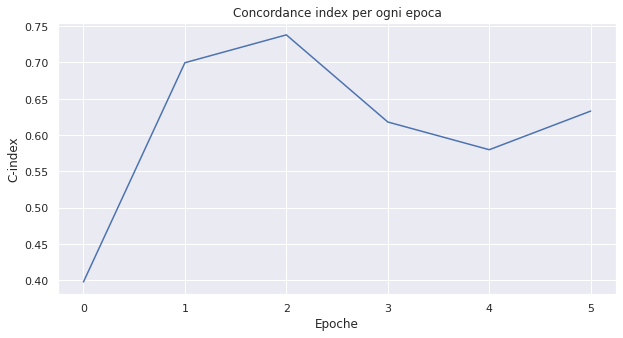

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,5)})
sns.lineplot(np.arange(len(c)),c )
plt.xlabel('Epoche')
plt.ylabel('C-index')
plt.title('Concordance index per ogni epoca')
plt.savefig('Epoc.png')

In [23]:

def _f_get_pred(sess, model, _data, _data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(_data))
    new_data_mi = np.zeros(np.shape(_data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(_data)[0], 1]), np.cumsum(_data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(_data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = _data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = _data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)

In [24]:
## Curve e surv prob
risk_all = f_get_risk_predictions(sess, model, datate, data_mite, pred_time, eval_time)

r = risk_all[0]

In [25]:
p = np.zeros((903,16 , 26))
def f_get_pred_mod(model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)

for nn,pred_time in enumerate(np.linspace(0,15,16)):
  p[:,nn , :] = f_get_pred_mod(model , datate, data_mite , pred_time)[:,0,:]

In [26]:
S = np.zeros((903,16,26))
S[:,0,:] = 1
for i in range(1,16):
  for j in range(903):
    S[j,i,:] = S[j,i-1,:] * (1 - p[j,i-1,:])
i    

15

metrics



In [27]:
t = []
for i in range(903):
  m =(S[i,:,25])<0.98
  if sum(m)== 0:
    t.append(15)
  else:
    t.append(np.linspace(0,15,16)[m][0])

t = np.array(t)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

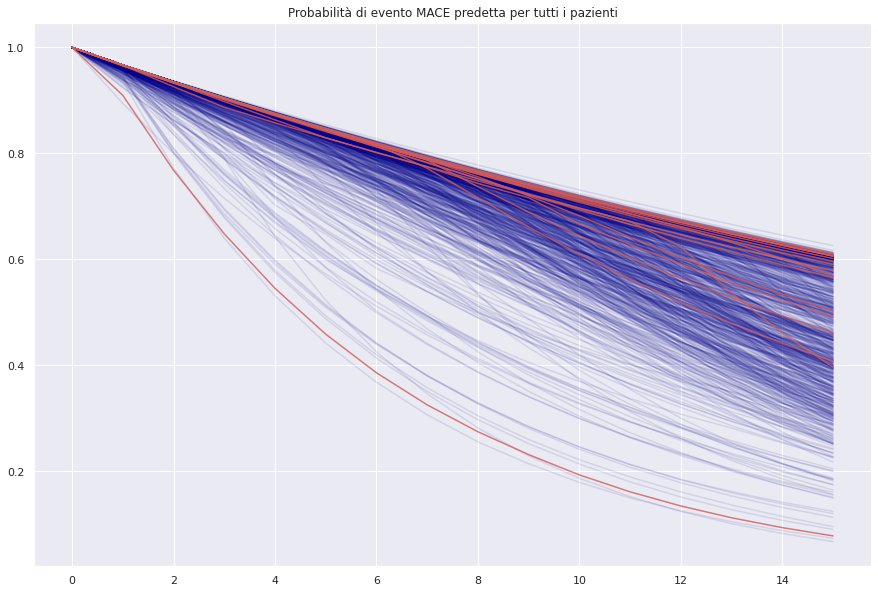

In [28]:
label = labelte
sum(label)
#
#cind = []
#risk = np.zeros(shape=(903  ,15))
#for t, t_time in enumerate(np.arange(0,15,1)):
#  eval_horizon = int(t_time)
#  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 903  )
#
#risk = pd.DataFrame(risk)
sns.set(rc={'figure.figsize':(15,10)})
for i in range(903 ):
  if label[i] == 0:
    sns.lineplot(np.arange(0,16,1),S[i,:,25] , alpha = .1, color = 'darkblue')


for i in range(903  ):
  if label[i] == 1:
    sns.lineplot(np.arange(0,16,1),S[i,:,25] , alpha = .8, color = 'indianred')
plt.title('Probabilità di evento MACE predetta per tutti i pazienti')  
plt.savefig('sop_pred.png')


In [29]:
t = []
for i in range(903):
  m =(S[i,:,25])<0.98
  if sum(m)== 0:
    t.append(15)
  else:
    t.append(np.linspace(1,15,16)[m][0])

t = np.array(t)
t
time_pred = t
time_true = timete
MSE_e = np.mean(np.square(time_true[np.reshape(labelte , 903) == 1]-time_pred[np.reshape(labelte , 903) == 1]))
MSE_a = np.mean(np.square(time_true[np.reshape(timete , 903) <= 15]-time_pred[np.reshape(timete , 903) <= 15]))
cnt = 0
for i in range(903):
  if time_true[i] <= 15:
    if time_true[i] < time_pred[i]:
      cnt +=1
perc = cnt/sum(time_true <= 15)    

In [30]:
t = []
for i in range(903):
  m =(S[i,:,25])<0.98
  if sum(m)== 0:
    t.append(15)
  else:
    t.append(np.linspace(1,15,16)[m][0])

t = np.array(t)
t
time_pred = t
time_true = timete
MSE_e = np.mean(np.square(time_true[np.reshape(labelte , 903) == 1]-time_pred[np.reshape(labelte , 903) == 1]))
MSE_a = np.mean(np.square(time_true[np.reshape(timete , 903) <= 15]-time_pred[np.reshape(timete , 903) <= 15]))
cnt = 0
for i in range(903):
  if time_true[i] <= 15:
    if time_true[i] < time_pred[i]:
      cnt +=1
perc = cnt/sum(time_true <= 15)    
print(MSE_e)
print(MSE_a)
print(perc)



53.88086828025526
46.00548146332629
[0.10599721]


In [31]:
lab_pred = time_pred != 15.

In [32]:
for eva in range(26): 
  t = []
  for i in range(903):
    m =(S[i,:,eva])<0.98
    if sum(m)== 0:
      t.append(15)
    else:
      t.append(np.linspace(1,15,16)[m][0])

  t = np.array(t)
  t
  time_pred = t
  time_true = timete
  MSE_e = np.mean(np.square(time_true[np.reshape(labelte , 903) == 1]-time_pred[np.reshape(labelte , 903) == 1]))
  MSE_a = np.mean(np.square(time_true[np.reshape(timete , 903) <= 15]-time_pred[np.reshape(timete , 903) <= 15]))
  cnt = 0
  for i in range(903):
    if time_true[i] <= 15:
      if time_true[i] < time_pred[i]:
        cnt +=1
  perc = cnt/sum(time_true <= 15)    


  lab_pred = time_pred != 15.
  TP = sum(np.diag(np.multiply(lab_pred,labelte)))
  TN = sum(np.diag(labelte+lab_pred) == 0)
  FP = sum(lab_pred) - TP
  FN = sum(lab_pred==False) - TN
  print(eva)
  print("sens:"  + str(TP / (TP+FN)) + "acc:" + str((TP+TN)/(TP+TN+FP+FN))+ "sec:" + str((TN)/(TN+FP)) + ' ' + str(MSE_e) + ' ' +str(MSE_a) + ' ' + str(perc))
  

0
sens:0.9444444444444444acc:0.02768549280177187sec:0.00903954802259887 54.203582785392015 45.70157234938202 [0.11157601]
1
sens:0.9444444444444444acc:0.018826135105204873sec:0.0 54.203582785392015 45.818077297321764 [0.10739191]
2
sens:1.0acc:0.019933554817275746sec:0.0 52.53739264011138 45.92108931114498 [0.10739191]
3
sens:0.9444444444444444acc:0.019933554817275746sec:0.0011299435028248588 54.203582785392015 45.74834720858774 [0.10739191]
4
sens:0.9444444444444444acc:0.018826135105204873sec:0.0 54.203582785392015 45.865091729570366 [0.10739191]
5
sens:1.0acc:0.019933554817275746sec:0.0 53.27478351386733 45.97954436962567 [0.10599721]
6
sens:1.0acc:0.019933554817275746sec:0.0 53.88086828025526 46.00548146332629 [0.10599721]
7
sens:1.0acc:0.019933554817275746sec:0.0 53.88086828025526 46.00548146332629 [0.10599721]
8
sens:1.0acc:0.019933554817275746sec:0.0 53.88086828025526 46.00548146332629 [0.10599721]
9
sens:1.0acc:0.019933554817275746sec:0.0 53.88086828025526 46.00548146332629 [0.1

In [33]:
pred_time = np.arange(0,16,1)

saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, datate, data_mite, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], timete, (labelte[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], timete, (labelte[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
    
c = np.mean(final1)

INFO:tensorflow:Restoring parameters from PBC2/model


In [34]:
c_m = c


In [35]:
label = labelte
sum(label)
p = model.predict( datate , data_mite)

p.shape
cind = []
risk = np.zeros(shape=(903  ,3000))
for t, t_time in enumerate(np.linspace(1,15,3000 )):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 903  )

risk = pd.DataFrame(risk)


In [36]:
time_pred = np.zeros(903)
t = np.linspace(0,15,3000)
for k in range(903):
  if sum((risk.loc[k,:]>0.02))>0:
    time_pred[k] = t[(risk.loc[k,:]>0.02)][0]
  else:
    time_pred[k] = 15


In [37]:
time_true = timete
MSE_e = np.mean(np.square(time_true[np.reshape(labelte , 903) == 1]-time_pred[np.reshape(labelte , 903) == 1]))
MSE_a = np.mean(np.square(time_true[np.reshape(timete , 903) <= 15]-time_pred[np.reshape(timete , 903) <= 15]))
cnt = 0
for i in range(903):
  if time_true[i] <= 15:
    if time_true[i] < time_pred[i]:
      cnt +=1
perc = cnt/sum(time_true <= 15)    

In [38]:
sum(labelte)

array([18.])

In [39]:
print(MSE_e)
print(MSE_a)
print(perc)


74.19243717079267
56.63165538740909
[0.]


In [40]:
lab_pred = time_pred != 15.

In [41]:
TP = sum(np.diag(np.multiply(lab_pred,labelte)))
TN = sum(np.diag(labelte+lab_pred) == 0)
FP = sum(lab_pred) - TP
FN = sum(lab_pred==False) - TN
print("sens:"  + str(TP / (TP+FN)))
print("acc:" + str((TP+TN)/(TP+TN+FP+FN)))

print("sec:" + str((TN)/(TN+FP)))
print(str(TP)+"|"+str(FN))
print(str(FP)+"|"+str(TN))


sens:1.0
acc:0.019933554817275746
sec:0.0
18.0|0
885.0|0


In [42]:
def import_dataset_shuffle( data_s , data_mi_s  , col , norm_mode = 'standard'):
    
    data_s_mod = data_s.copy()
    data_mi_s_mod = data_mi_s.copy()
    data_mi_s = None
    data_s = None

    bin_list           = ['anno_inizio_ARV' ,  'FDRn','HCV' ]
    cont_list          = [ 'AGE_UPD' ,'ipert_si_no'   , 'PLT' ,
                            'INI_time_exp' , "PI_time_exp" , 'NNRTI_time_exp']
    feat_list  =  cont_list + bin_list
    bin_list           = ['anno_inizio_ARV' ,  'FDRn','HCV' ]
    cont_list          = [ 'time','AGE_UPD' ,'ipert_si_no'   , 'PLT' ,
                            'INI_time_exp' , "PI_time_exp" , 'NNRTI_time_exp']

    column  =  cont_list + bin_list

    i = -1
    column = feat_list
    for j in range(len(column)):
      if column[j] == col:
        i = j
    s = np.random.permutation(range(3609))  
    for k in range(len(data_s_mod[0,:,0])):


      data_s_mod[:,k,i] = (data_s_mod[s,k,i])
      data_mi_s_mod[:,k,i] = (data_mi_s_mod[s,k,i])
    
    
    return data_s_mod , data_mi_s_mod


In [43]:

bin_list           = ['anno_inizio_ARV' ,  'FDRn','HCV' ]
cont_list          = [ 'AGE_UPD' ,'ipert_si_no'   , 'PLT' ,
                        'INI_time_exp' , "PI_time_exp" , 'NNRTI_time_exp']
feat_list          = cont_list + bin_list

In [44]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'AGE_UPD' )
data_imp[0,1,:]

array([ 0.10403   ,  0.1610697 ,  2.33099034, -2.04664423, -0.32264794,
       -0.60324994,  1.03872529,  1.        ,  1.        ,  0.        ])

In [45]:
pred_time = np.arange(0,16,1)
risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

#risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)
for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_age = np.mean(df1,axis =1)[0]
c_age

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.973455     0.956315  ...      0.768711      0.769494
pred_time 1: event_1      0.891904     0.863092  ...      0.756347      0.759212
pred_time 2: event_1      0.802522     0.803529  ...      0.750805      0.743156
pred_time 3: event_1      0.770991     0.754996  ...      0.723472      0.725355
pred_time 4: event_1      0.740571     0.739743  ...      0.694012      0.697653
pred_time 5: event_1      0.706096     0.703050  ...      0.689321      0.688908
pred_time 6: event_1      0.699105     0.694850  ...      0.689252      0.686600
pred_time 7: event_1      0.704418     0.714624  ...      0.706534      0.703144
pred_time 8: event_1      0.732438     0.734570  ...      0.724392      0.724579
pred_time 9: event_1      0.757359     0.760259  ...      0.749010      0.751706
pred_time 10: event_1     0.767593     0

0.8404752854115731

In [46]:

bin_list           = ['anno_inizio_ARV' ,  'FDRn','HCV' ]
cont_list          = [ 'AGE_UPD' ,'ipert_si_no'   , 'PLT' ,
                        'INI_time_exp' , "PI_time_exp" , 'NNRTI_time_exp']
feat_list          = cont_list + bin_list
feat_list

['AGE_UPD',
 'ipert_si_no',
 'PLT',
 'INI_time_exp',
 'PI_time_exp',
 'NNRTI_time_exp',
 'anno_inizio_ARV',
 'FDRn',
 'HCV']

In [47]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'ipert_si_no')



In [48]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_ipert_si_no = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.755151     0.764995  ...      0.661225      0.659693
pred_time 1: event_1      0.538344     0.524622  ...      0.602850      0.601461
pred_time 2: event_1      0.495547     0.541505  ...      0.593155      0.582109
pred_time 3: event_1      0.479518     0.529815  ...      0.548358      0.550110
pred_time 4: event_1      0.496306     0.508343  ...      0.561024      0.566234
pred_time 5: event_1      0.521791     0.551878  ...      0.579676      0.579839
pred_time 6: event_1      0.599499     0.615433  ...      0.607903      0.603125
pred_time 7: event_1      0.633871     0.624812  ...      0.610624      0.606246
pred_time 8: event_1      0.670635     0.657772  ...      0.641773      0.640903
pred_time 9: event_1      0.690703     0.703352  ...      0.671483      0.677713
pred_time 10: event_1     0.737664     0

In [49]:
feat_list

['AGE_UPD',
 'ipert_si_no',
 'PLT',
 'INI_time_exp',
 'PI_time_exp',
 'NNRTI_time_exp',
 'anno_inizio_ARV',
 'FDRn',
 'HCV']

In [50]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'PI_time_exp')


In [51]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_PI_time_exp = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.967229     0.847358  ...      0.731560      0.730559
pred_time 1: event_1      0.586525     0.627171  ...      0.656165      0.656190
pred_time 2: event_1      0.702436     0.679079  ...      0.676174      0.665291
pred_time 3: event_1      0.619179     0.640208  ...      0.618981      0.620407
pred_time 4: event_1      0.635036     0.642954  ...      0.623403      0.628644
pred_time 5: event_1      0.643479     0.637350  ...      0.636262      0.635987
pred_time 6: event_1      0.632711     0.635992  ...      0.626311      0.622577
pred_time 7: event_1      0.652849     0.652483  ...      0.634029      0.629632
pred_time 8: event_1      0.684822     0.675115  ...      0.647609      0.647396
pred_time 9: event_1      0.696779     0.695776  ...      0.668230      0.676024
pred_time 10: event_1     0.722333     0

In [52]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'NRTI_time_exp')


In [53]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_NRTI_time_exp = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.974360     0.957718  ...      0.767954      0.768825
pred_time 1: event_1      0.872836     0.806396  ...      0.733355      0.732904
pred_time 2: event_1      0.862860     0.848793  ...      0.749980      0.736013
pred_time 3: event_1      0.867698     0.848222  ...      0.729552      0.732348
pred_time 4: event_1      0.854683     0.852729  ...      0.754302      0.765272
pred_time 5: event_1      0.882965     0.858352  ...      0.778639      0.778251
pred_time 6: event_1      0.880846     0.880304  ...      0.786501      0.773604
pred_time 7: event_1      0.869402     0.846848  ...      0.761151      0.748722
pred_time 8: event_1      0.870156     0.845748  ...      0.771027      0.772103
pred_time 9: event_1      0.859903     0.859644  ...      0.790304      0.806497
pred_time 10: event_1     0.874975     0

In [54]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'NNRTI_time_exp')


In [55]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_NNRTI_time_exp = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.971134     0.951054  ...      0.738485      0.739910
pred_time 1: event_1      0.782724     0.734458  ...      0.668180      0.667674
pred_time 2: event_1      0.682583     0.682089  ...      0.653951      0.645845
pred_time 3: event_1      0.651574     0.678112  ...      0.640359      0.640803
pred_time 4: event_1      0.669497     0.677742  ...      0.652174      0.652637
pred_time 5: event_1      0.646821     0.659012  ...      0.638552      0.638977
pred_time 6: event_1      0.672814     0.674318  ...      0.641679      0.639227
pred_time 7: event_1      0.699418     0.674692  ...      0.659336      0.655239
pred_time 8: event_1      0.707849     0.701731  ...      0.679201      0.680533
pred_time 9: event_1      0.715871     0.725271  ...      0.695395      0.701837
pred_time 10: event_1     0.750121     0

In [56]:
feat_list

['AGE_UPD',
 'ipert_si_no',
 'PLT',
 'INI_time_exp',
 'PI_time_exp',
 'NNRTI_time_exp',
 'anno_inizio_ARV',
 'FDRn',
 'HCV']

In [57]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'anno_inizio_ARV')


In [58]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_anno_inizio_ARV = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.964569     0.944453  ...      0.741544      0.739347
pred_time 1: event_1      0.642677     0.646414  ...      0.649222      0.648847
pred_time 2: event_1      0.545106     0.592135  ...      0.605527      0.599153
pred_time 3: event_1      0.603889     0.595091  ...      0.596032      0.596201
pred_time 4: event_1      0.594315     0.601403  ...      0.620732      0.623090
pred_time 5: event_1      0.608509     0.594194  ...      0.631296      0.631252
pred_time 6: event_1      0.598912     0.618260  ...      0.623259      0.622277
pred_time 7: event_1      0.614426     0.604363  ...      0.608860      0.603719
pred_time 8: event_1      0.641147     0.628868  ...      0.630145      0.630108
pred_time 9: event_1      0.650471     0.661300  ...      0.652512      0.658886
pred_time 10: event_1     0.682920     0

In [59]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'HCV')


In [60]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_HCV = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.969493     0.960046  ...      0.762460      0.763459
pred_time 1: event_1      0.847103     0.791217  ...      0.729739      0.731384
pred_time 2: event_1      0.842270     0.831640  ...      0.747991      0.739678
pred_time 3: event_1      0.854622     0.837303  ...      0.737070      0.738590
pred_time 4: event_1      0.844077     0.845178  ...      0.762320      0.768975
pred_time 5: event_1      0.879407     0.857873  ...      0.790379      0.790323
pred_time 6: event_1      0.873015     0.876205  ...      0.792912      0.785469
pred_time 7: event_1      0.863615     0.838007  ...      0.765904      0.755903
pred_time 8: event_1      0.856209     0.829952  ...      0.770095      0.771552
pred_time 9: event_1      0.844708     0.847699  ...      0.786126      0.801706
pred_time 10: event_1     0.865556     0

In [61]:
feat_list

['AGE_UPD',
 'ipert_si_no',
 'PLT',
 'INI_time_exp',
 'PI_time_exp',
 'NNRTI_time_exp',
 'anno_inizio_ARV',
 'FDRn',
 'HCV']

In [62]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'FDRn')

In [63]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_FDR = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.937571     0.930168  ...      0.746250      0.747015
pred_time 1: event_1      0.832180     0.770416  ...      0.710006      0.708717
pred_time 2: event_1      0.764416     0.760735  ...      0.711269      0.692386
pred_time 3: event_1      0.719835     0.735838  ...      0.665991      0.668631
pred_time 4: event_1      0.719309     0.725053  ...      0.676618      0.687689
pred_time 5: event_1      0.764597     0.763846  ...      0.709424      0.709224
pred_time 6: event_1      0.792721     0.787405  ...      0.721446      0.714146
pred_time 7: event_1      0.788598     0.772544  ...      0.702675      0.689628
pred_time 8: event_1      0.796943     0.776004  ...      0.712739      0.712808
pred_time 9: event_1      0.797814     0.799963  ...      0.730015      0.750674
pred_time 10: event_1     0.821149     0

In [64]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'INI_time_exp')


In [65]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_INI_time_exp = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.962192     0.907784  ...      0.708997      0.710168
pred_time 1: event_1      0.667517     0.679235  ...      0.673003      0.672646
pred_time 2: event_1      0.651719     0.675830  ...      0.665065      0.657141
pred_time 3: event_1      0.612044     0.649374  ...      0.627812      0.629682
pred_time 4: event_1      0.666629     0.675746  ...      0.641954      0.650298
pred_time 5: event_1      0.698968     0.672921  ...      0.640022      0.639609
pred_time 6: event_1      0.726337     0.731586  ...      0.684405      0.676136
pred_time 7: event_1      0.734095     0.718657  ...      0.671777      0.665503
pred_time 8: event_1      0.753772     0.735980  ...      0.697465      0.697396
pred_time 9: event_1      0.759962     0.760821  ...      0.724229      0.731616
pred_time 10: event_1     0.786674     0

In [66]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'PLT')


In [67]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_plt = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.972096     0.955359  ...      0.762568      0.761932
pred_time 1: event_1      0.629923     0.645845  ...      0.663195      0.660962
pred_time 2: event_1      0.645740     0.680974  ...      0.657804      0.645782
pred_time 3: event_1      0.606836     0.621851  ...      0.604276      0.606052
pred_time 4: event_1      0.580816     0.605190  ...      0.612776      0.617117
pred_time 5: event_1      0.603981     0.617226  ...      0.614715      0.614746
pred_time 6: event_1      0.657250     0.658008  ...      0.633836      0.631109
pred_time 7: event_1      0.681518     0.670354  ...      0.643230      0.641529
pred_time 8: event_1      0.703949     0.697241  ...      0.670764      0.670445
pred_time 9: event_1      0.725452     0.729191  ...      0.694381      0.699229
pred_time 10: event_1     0.757278     0

In [68]:

risk_all = f_get_risk_predictions(sess, model, tr_data, tr_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 1  eval_time 2  ...  eval_time 14  eval_time 15
pred_time 0: event_1      0.973455     0.956315  ...      0.768552      0.769332
pred_time 1: event_1      0.927553     0.843428  ...      0.747941      0.747515
pred_time 2: event_1      0.896503     0.873734  ...      0.763684      0.749292
pred_time 3: event_1      0.889071     0.864801  ...      0.741054      0.743687
pred_time 4: event_1      0.867443     0.863918  ...      0.762208      0.773416
pred_time 5: event_1      0.892524     0.865664  ...      0.786970      0.786657
pred_time 6: event_1      0.885633     0.885702  ...      0.793994      0.780884
pred_time 7: event_1      0.874641     0.849583  ...      0.764922      0.750955
pred_time 8: event_1      0.872222     0.847435  ...      0.773279      0.773866
pred_time 9: event_1      0.863900     0.865108  ...      0.790310      0.810857
pred_time 10: event_1     0.880759     0

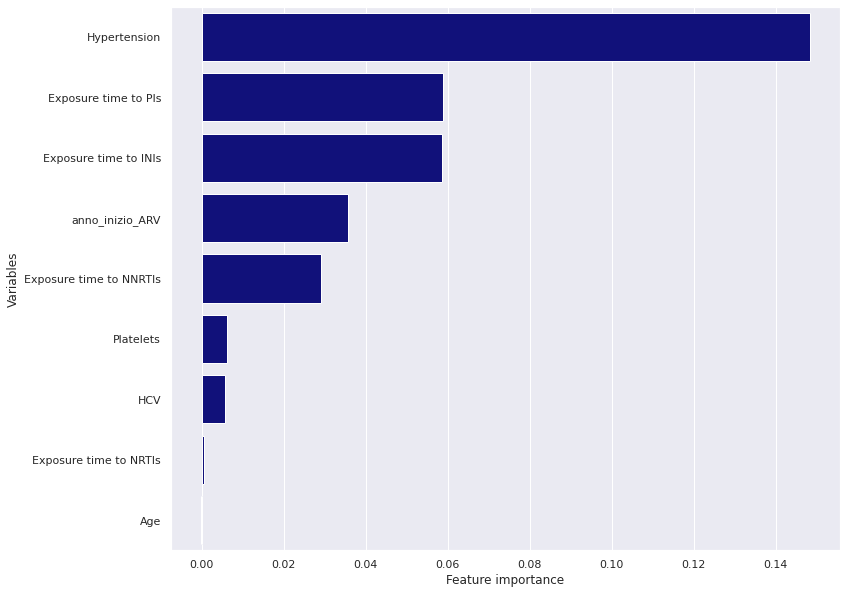

In [69]:
sns.set(rc={'figure.figsize':(12,10)})
c_m = np.mean(c)
d = pd.DataFrame({'Variables':['Age' , 'Hypertension' ,
                             'Platelets' , "Exposure time to PIs" , 'Exposure time to NRTIs' , 'Exposure time to NNRTIs',
                             'anno_inizio_ARV' , 'HCV' , 'Exposure time to INIs'], 
                  'Feature importance':[c_m-c_age ,
                           c_m-c_ipert_si_no , c_m-c_plt , c_m-c_PI_time_exp , c_m-c_NRTI_time_exp , c_m-c_NNRTI_time_exp , 
                             c_m-c_anno_inizio_ARV ,c_m-c_HCV ,  c_m-c_INI_time_exp]})
d.sort_values(by=['Feature importance'],
                               ascending=False, inplace=True)
sns.barplot(y = 'Variables',x= 'Feature importance',data=d, color= 'darkblue', orient= 'h')
plt.savefig('feature_imp1.png')